# Прогнозирование временных рядов

# Итоговый проект по курсу "Прикладная аналитика данных"

### Проект выполнил Коротков Илья

In [ ]:
# Data analysis
import numpy as np
import pandas as pd
from math import sqrt
import datetime

from statsmodels.tsa.stattools import adfuller

pd.options.mode.chained_assignment = None  # default='warn'

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from tqdm import tqdm

plt.rcParams['figure.figsize'] = [10, 5]
init_notebook_mode(connected=True)

# Models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

from itertools import product

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from fbprophet import Prophet

# 1. Введение

Коронавирус появился почти два года назад, но он до сих пор оказывает большое влияние на нашу жизнь. Поэтому прогнозирование заражений, смертей и выздоровлений от него актуальная задача в настоящее время.

Разработанные модели смогут помочь государствам рассчитывать нагрузку на систему здравоохранения, организаторам мероприятий заранее принимать решение об их переносе, а компаниям прогнозировать изменения прибыли из-за периодов локдауна.

Вопросы, на которые направлено данное исследование:

*   Можно ли прогнозировать временные ряды заражаемости, смертности и выздоровлений от коронавируса?
*   Какие модели машинного обучения можно для этого использовать?
*   Чем эти модели различаются?

# 2. Загрузка данных

Данные взяты с сайта kaggle: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

Загрузим датасет, переименуем его столбцы, изменим тип некоторых столбцов на дату/время.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2021.12.15 VK Итоговый проект/covid_19_data.csv', index_col=0)
# Rename columns
df = df.rename(columns={
    'ObservationDate': 'date',
    'Province/State': 'state',
    'Country/Region': 'country',
    'Last Update': 'last_update',
    'Confirmed': 'confirmed',
    'Deaths': 'deaths',
    'Recovered': 'recovered'
})
# Convert 'date' and 'last_update' columns to datetime format
df['date'] = pd.to_datetime(df['date'])
df['last_update'] = pd.to_datetime(df['last_update'])

Посмотрим на загруженные нами данные.

In [ ]:
df.head()

,date,state,country,last_update,confirmed,deaths,recovered
SNo,,,,,,,
1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


In [ ]:
df.shape

(306429, 7)

In [ ]:
df['date'].min(), df['date'].max()

(Timestamp('2020-01-22 00:00:00'), Timestamp('2021-05-29 00:00:00'))

In [ ]:
df['date'].max() - df['date'].min()

Timedelta('493 days 00:00:00')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306429 entries, 1 to 306429
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         306429 non-null  datetime64[ns]
 1   state        228329 non-null  object        
 2   country      306429 non-null  object        
 3   last_update  306429 non-null  datetime64[ns]
 4   confirmed    306429 non-null  float64       
 5   deaths       306429 non-null  float64       
 6   recovered    306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 18.7+ MB


В нашем датасете примерно 300 тысяч наблюдений о количестве заражений, смертей и выздоровлений для разных стран и регионов за каждый день.

Этот датасет охватывает период длиной 493 дня, с 22 января 2020 года по 29 мая 2021 года.

В датасете есть пропуски, но они наблюдаются только в столбце штата/региона. Так как я не буду работать с этим столбцом, пропуски можно проигнорировать.

# 3. Предобработка данных

Сгруппируем весь датасет по датам и странам, чтобы получить значения для каждой страны в целом, а не их регионов отдельно.

In [ ]:
df = df.groupby(['date', 'country']).sum().reset_index().sort_values(['country', 'date'])

Признаки количества заражений, смертей и выздоровлений в датасете являются кумулятивными. Это можно понять по графику ниже.

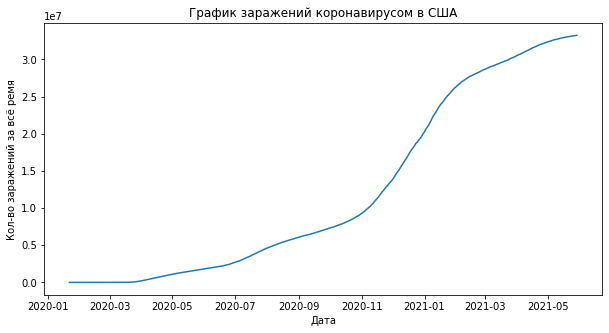

In [ ]:
plt.title('График заражений коронавирусом в США')

plt.xlabel('Дата')
plt.ylabel('Кол-во заражений за всё ремя')

sns.lineplot(data=df[df['country'] == 'US'], x='date', y='confirmed');

Создадим новые столбцы, которые будут хранить количество новых случаев (динамику изменения).

In [ ]:
# Create new columns with differences
df['new_confirmed'] = df['confirmed'].diff().fillna(0)
df['new_deaths'] = df['deaths'].diff().fillna(0)
df['new_recovered'] = df['recovered'].diff().fillna(0)

# Correct border values
mask = df['country'] != df['country'].shift(1)
df['new_confirmed'][mask] = 0
df['new_deaths'][mask] = 0
df['new_recovered'][mask] = 0

Проверим, нет ли отрицательных значений в полученных столбцах.

In [ ]:
(df['new_confirmed'] < 0).sum(),\
(df['new_deaths'] < 0).sum(),\
(df['new_recovered'] < 0).sum()

(88, 89, 142)

Наши новые признаки принимают значения меньше нуля. Это происходит из-за того, что наши кумулятивные признаки не всегда неубывают. Скорее всего это ошибка в данных, поэтому просто заменим все отрицательные значения на нули.

In [ ]:
# Replace negative values with 0
df['new_confirmed'][df['new_confirmed'] < 0] = 0
df['new_deaths'][df['new_deaths'] < 0] = 0
df['new_recovered'][df['new_recovered'] < 0] = 0

После всех преобразований получили новый датасет, который хранит динамику заражений, смертей и выздоровлений для каждой страны.

In [ ]:
df.head()

,date,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
1104,2020-02-28,Azerbaijan,1.0,0.0,0.0,0.0,0.0,0.0
2068,2020-03-10,"('St. Martin',)",2.0,0.0,0.0,0.0,0.0,0.0
914,2020-02-24,Afghanistan,1.0,0.0,0.0,0.0,0.0,0.0
954,2020-02-25,Afghanistan,1.0,0.0,0.0,0.0,0.0,0.0
998,2020-02-26,Afghanistan,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(87281, 8)

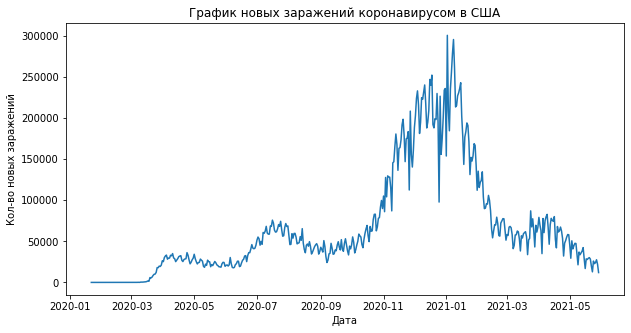

In [ ]:
plt.title('График новых заражений коронавирусом в США')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений')

sns.lineplot(data=df[df['country'] == 'US'], x='date', y='new_confirmed');

In [ ]:
df.to_csv('covid_data.csv')

# 4. Визуализации

Для проверки нашего датасета построим несколько визуализаций.

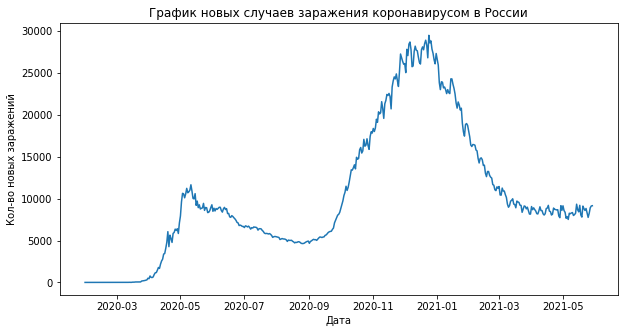

In [ ]:
plt.title('График новых случаев заражения коронавирусом в России')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений')

sns.lineplot(data=df[df['country'] == 'Russia'], x='date', y='new_confirmed');

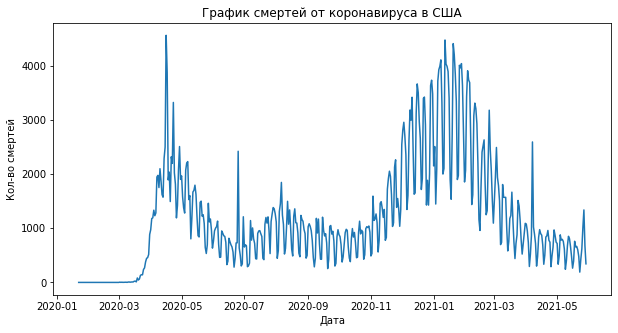

In [ ]:
plt.title('График смертей от коронавируса в США')

plt.xlabel('Дата')
plt.ylabel('Кол-во смертей')

sns.lineplot(data=df[df['country'] == 'US'], x='date', y='new_deaths');

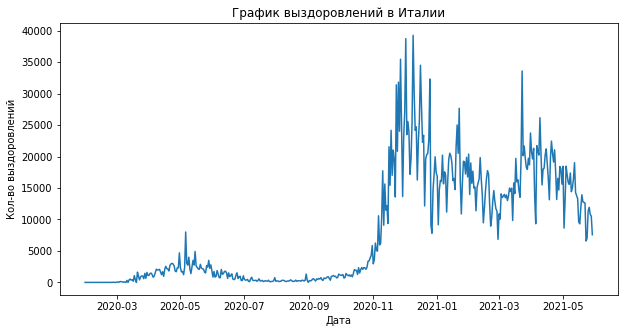

In [ ]:
plt.title('График выздоровлений в Италии')

plt.xlabel('Дата')
plt.ylabel('Кол-во выздоровлений')

sns.lineplot(data=df[df['country'] == 'Italy'], x='date', y='new_recovered');

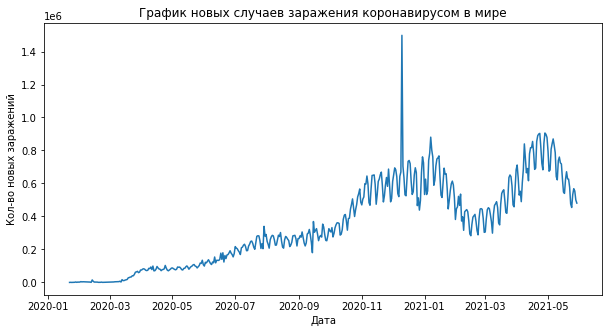

In [ ]:
plt.title('График новых случаев заражения коронавирусом в мире')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений')

sns.lineplot(data=df.groupby('date').sum().reset_index(), x='date', y='new_confirmed');

Видим на последнем графике явную аномалию. Она возникала из-за того, что, по нашим данным, в Турции 10 декабря 2020 года количество новых заражений составило 823 тысячи.

In [ ]:
df[(df['country'] == 'Turkey') & (df['date'] == '2020-12-10')]

,date,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
54157,2020-12-10,Turkey,1748567.0,15751.0,452593.0,823225.0,220.0,5232.0


Эта аномалия также есть на графиках Google

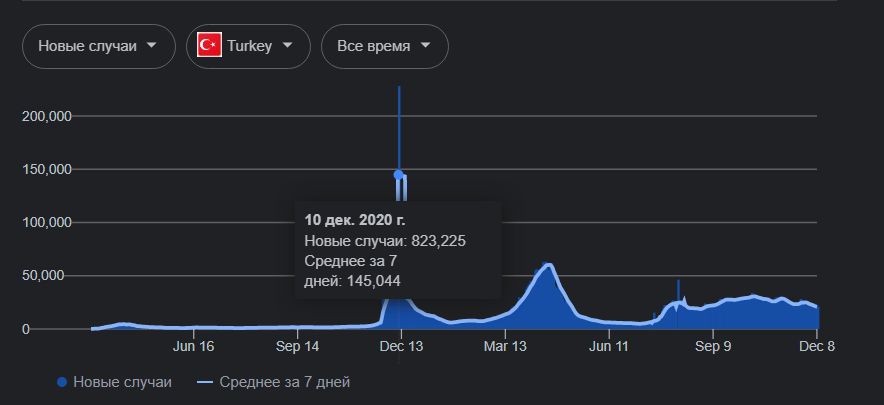

и mail.ru

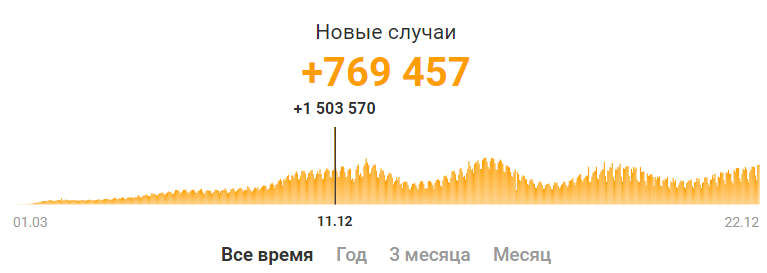

Я допускаю наличие подобных аномалий в датасете, но не буду бороться с ними в этой работе, так как это не является целью исследования.

Из-за этого может пострадать качество обученных моделей, но эти модели можно будет адаптировать для поиска таких аномалий.

# 5. Сравнение моделей

Создадим отдельный датасет для суммы наблюдений по всему миру, по которому будем строить предсказания моделей и оценивать их.

In [ ]:
df_gl = df.groupby('date').sum().reset_index()

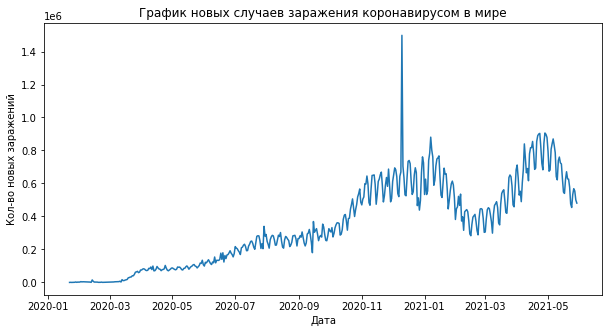

In [ ]:
plt.title('График новых случаев заражения коронавирусом в мире')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений')

sns.lineplot(data=df_gl, x='date', y='new_confirmed');

Проанализируем временной ряд. Декомпозируем его на компоненты.

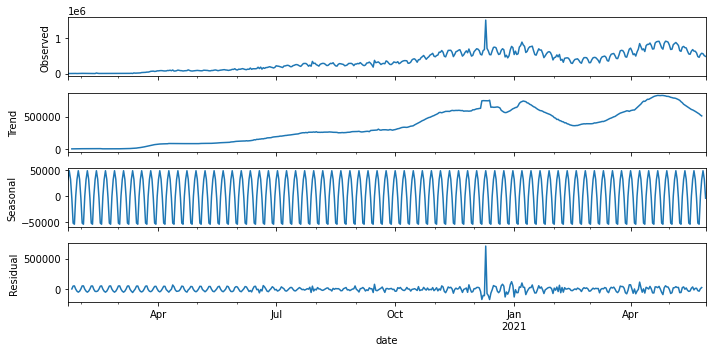

In [ ]:
fig = seasonal_decompose(df_gl.set_index('date')['new_confirmed']).plot()

In [ ]:
s = seasonal_decompose(df_gl.set_index('date')['new_confirmed']).seasonal.nunique()
print(f'Период сезонности: {s}')

Период сезонности: 7


Видим:

*   Нелинейный тренд, который связан с нескольими волнам коронавируса по всему миру.
*   Недельную сезонность, которая связана с разной работой больниц в выходные и рабочие дни.
*   Шум, в который попала аномалия, которую я описал в разделе визуализаций.



## 5.1. ARIMA

В качестве ряда для прогнозировная выберем количество новых заражений коронавирусом по всему миру.

In [ ]:
time_series = df_gl['new_confirmed']
time_series.index = df_gl['date']

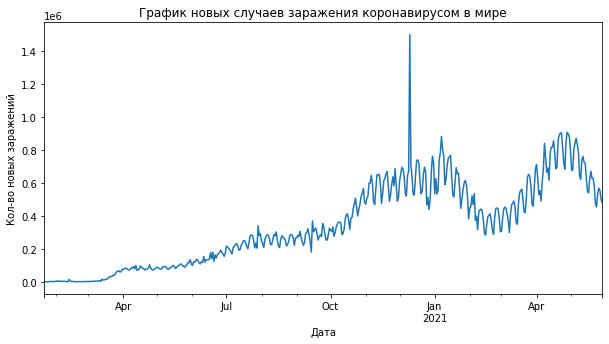

In [ ]:
time_series.plot()

plt.title('График новых случаев заражения коронавирусом в мире')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений');

Перед тем как обучать ARIMA модель, необходимо убедиться в стационарности временного ряда.

In [ ]:
def stationarity_test(series, alpha=0.05):
  test = adfuller(series)

  print(f'p-value: {test[1]}')
  if test[1] < alpha:
    print('Временной ряд стационарен')
  else:
    print('Временной ряд не стационарен')

In [ ]:
stationarity_test(time_series)

p-value: 0.43413618844096835
Временной ряд не стационарен


Получили, что наш временной ряд не стационарен.

Попробуем взять первые разницы ряда, чтобы избавиться от тренда, и проверим его на стационарность ещё раз.

In [ ]:
time_series_diff1 = time_series.diff(1).fillna(0)

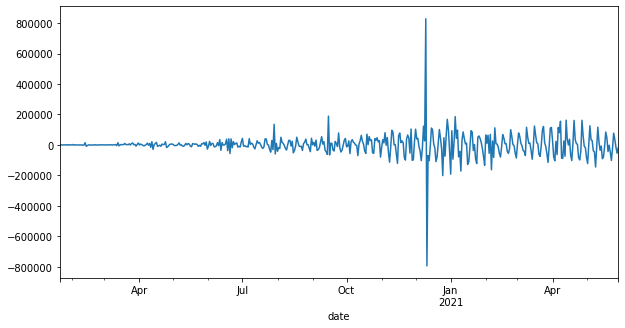

In [ ]:
time_series_diff1.plot();

In [ ]:
stationarity_test(time_series_diff1)

p-value: 0.0001789771609681896
Временной ряд стационарен


Получили, что при взятии первых разниц наш ряд уже становится стационарным.

Построим графики полной и частичной автокорреляции.

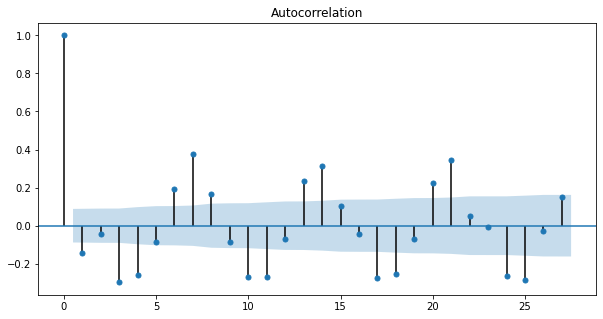

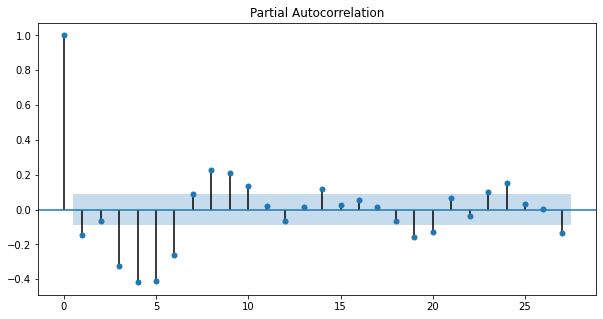

In [ ]:
fig1 = plot_acf(time_series_diff1)
fig2 = plot_pacf(time_series_diff1)

Разделим наш ряд на тренировочную и тестовую выборку.

In [ ]:
test_size = 30

series_train = time_series[:-test_size]
series_test = time_series[-test_size:]

Подберём гиперпараметры для модели.

**s** равен периоду сезонности. В нашем ряду видна явная недельная сезонность.

$$s = 7$$

**Q** равен номеру последнего значимого сезоннного лага на графике полной автокорреляции. На графике видно, что это 21 лаг.

$$Q = 21 / 7 = 3$$

**q** равен номеру последнего значимого лага, но не больше периода сезонности, на том же графике полной автокорреляции. На графике видно, что последний значимый лаг меньше 7, это лаг под номером 6.

$$q = 6$$

**P** равен номеру последного значимого сезонного лага на графике частичной автокорреляции. На графике видно, что это 7 лаг.

$$P = 7 / 7 = 1$$

**p** равен номеру последнего значимого лага, но не больше периода сезонности, на том же графике частичной автокорреляции. На графике видно, что последний значимый лаг меньше 7, это лаг под номером 6.

$$p = 6$$

Зададим сетку из значений в окрестности подобранных гиперпараметров модели и найдём наилучшую их комбинацию.

In [ ]:
p = 6
d = 1
q = 6
P = 1
D = 1
Q = 3
s = 7

p = range(p-1, p+2)
d = range(d, d+1)
q = range(q-1, q+1)
P = range(P-1, P+2)
D = range(D, D+1)
Q = range(Q-1, Q+2)

params_list = list(product(p, d, q, P, D, Q))

print(f'Количество переборов: {len(params_list)}')

Количество переборов: 54


In [ ]:
best_aic = float("inf")
best_model = None
best_param = None

for param in tqdm(params_list):
  # Fit model
  try:
    model = SARIMAX(series_train.values,
                    order=(param[0], param[1], param[2]),
                    seasonal_order=(param[3], param[4], param[5], s)).fit()
  except:
    pass

  # Save best model
  if model.aic < best_aic:
    best_aic = model.aic
    best_model = model
    best_param = param

  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  2%|▏         | 1/54 [00:13<11:49, 13.38s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  4%|▎         | 2/54 [00:36<16:34, 19.12s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  6%|▌         | 3/54 [01:10<21:54, 25.77s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  7%|▋         | 4/54 [01:24<17:44, 21.28s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed 

Получили лучшую комбинацию гиперпараметров модели ARIMA для нашего временного ряда.

In [ ]:
print('Подобранные гиперпараметры:')
print(f'p: {best_param[0]}')
print(f'd: {best_param[1]}')
print(f'q: {best_param[2]}')
print(f'P: {best_param[3]}')
print(f'D: {best_param[4]}')
print(f'Q: {best_param[5]}')

Подобранные гиперпараметры:
p: 7
d: 1
q: 5
P: 0
D: 1
Q: 2


In [ ]:
%%time
model_arima = SARIMAX(series_train.values,
                    order=(7, 1, 5),
                    seasonal_order=(0, 1, 2, s)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 17.8 s, sys: 12.6 s, total: 30.4 s
Wall time: 26.1 s


Построим графики для тренировочных, подогнанных, тестовых и спрогнозированных значений и доверительный интервал для последних. Рассчитаем метрику MAE на тренировочных и подогнанных данных.

In [ ]:
forecast_df = model_arima.get_forecast(steps=series_test.size).summary_frame(alpha=0.05)
forecast_values = forecast_df['mean']
forecast_lower = forecast_df['mean_ci_lower']
forecast_upper = forecast_df['mean_ci_upper']

fitted_values = model_arima.fittedvalues

# Create lines for all values
trace_real = go.Scatter(x=series_test.index, y=series_test, name='Test values')
trace_forecast = go.Scatter(x=series_test.index, y=forecast_values, name='Forecast values', line=dict(color='orange'))
trace_train = go.Scatter(x=series_train.index, y=series_train, name='Train values')
trace_fitted = go.Scatter(x=series_train.index, y=fitted_values, name='Fitted values')

trace_forecast_lower = go.Scatter(
        name='80% сonfidence interval',
        x=series_test.index,
        y=forecast_lower,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        legendgroup='Confidence interval',
        showlegend=False)
trace_forecast_upper = go.Scatter(
        name='80% сonfidence interval',
        x=series_test.index,
        y=forecast_upper,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        legendgroup='Confidence interval',
        showlegend=True)

# Define the data array
data = [trace_real, trace_forecast, trace_train, trace_fitted,
        trace_forecast_lower, trace_forecast_upper]

# Calculate MAE metric
mae_metric = round(mae(series_train, fitted_values))

# Set the title
layout = {'title': f'New COVID-19 cases. MAE: {mae_metric} on train part',
          'yaxis_title': 'New cases',
          'xaxis_title': 'Date'}

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

Оценка модели ARIMA:

**+** Даёт точные предсказания для временного ряда

**-** Необходимо глубокое исследование ряда и приведение его к стационарному виду перед обучением модели

**-** Очень долгое обучение и подбор гиперпараметров модели

## 5.2. Тройное экспоненциальное сглаживание

В качестве ряда для прогнозировная выберем количество новых заражений коронавирусом по всему миру.

In [ ]:
time_series = df_gl['new_confirmed']
time_series.index = df_gl['date']

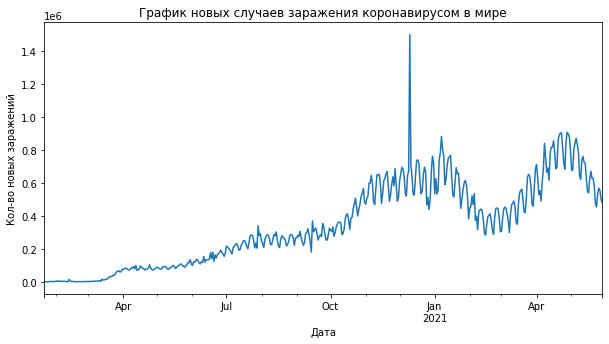

In [ ]:
time_series.plot()

plt.title('График новых случаев заражения коронавирусом в мире')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений');

Разделим временной ряд на тренировочную и тестовую части.

In [ ]:
test_size = 30

series_train = time_series[:-test_size]
series_test = time_series[-test_size:]

Инициализируем модель тройного эскпоненциального сглаживания. Определим аддитивный тип сезонной компоненты и период сезона равный семи. Обучим созданную модель.

In [ ]:
model_es = ExponentialSmoothing(series_train,
                                seasonal='add',
                                seasonal_periods=7,
                                freq='D').fit()

Спрогнозируем временной ряд на месяц вперед и рассчитаем доверительный интервал для этого прогноза.

In [ ]:
fitted_values = model_es.predict(start=series_train.index[0], end=series_train.index[-1])
forecast_values = model_es.predict(start=series_test.index[0], end=series_test.index[-1])

# Calculate errors std
std = (series_train - fitted_values).std()

forecast_lower = series_test.copy()
forecast_upper = series_test.copy()

h = 0
for date in series_test.index:
  h += 1

  forecast_lower.loc[date] = forecast_values.loc[date] - 1.28 * std * sqrt(h)
  forecast_upper.loc[date] = forecast_values.loc[date] + 1.28 * std * sqrt(h)

Построим графики для тренировочных, подогнанных, тестовых и спрогнозированных значений и доверительный интервал для последних. Рассчитаем метрику MAE на тренировочных и подогнанных данных.

In [ ]:
# Create lines for all values
trace_real = go.Scatter(x=series_test.index, y=series_test, name='Test values')
trace_forecast = go.Scatter(x=series_test.index, y=forecast_values, name='Forecast values', line=dict(color='orange'))
trace_train = go.Scatter(x=series_train.index, y=series_train, name='Train values')
trace_fitted = go.Scatter(x=series_train.index, y=fitted_values, name='Fitted values')

trace_forecast_lower = go.Scatter(
        name='80% сonfidence interval',
        x=series_test.index,
        y=forecast_lower,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        legendgroup='Confidence interval',
        showlegend=False)
trace_forecast_upper = go.Scatter(
        name='80% сonfidence interval',
        x=series_test.index,
        y=forecast_upper,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        legendgroup='Confidence interval',
        showlegend=True)

# Define the data array
data = [trace_real, trace_forecast, trace_train, trace_fitted,
        trace_forecast_lower, trace_forecast_upper]

# Calculate MAE metric
mae_metric = round(mae(series_train, fitted_values))

# Set the title
layout = {'title': f'New COVID-19 cases. MAE: {mae_metric} on train part',
          'yaxis_title': 'New cases',
          'xaxis_title': 'Date'}

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

Оценка модели тройного экспоненциального сглаживания:

**+** Очень быстрое обучение

**+** Необходим лишь минимальный анализ ряда перед обучением модели

**+** Хорошая точность предсказаний

## 5.3. Facebook Prophet

В качестве ряда для прогнозировная выберем количество новых заражений коронавирусом по всему миру.

In [ ]:
time_series = df_gl[['date', 'new_confirmed']]
time_series.columns = ['ds', 'y']

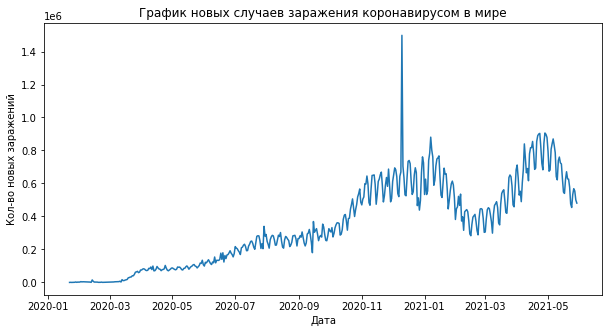

In [ ]:
plt.title('График новых случаев заражения коронавирусом в мире')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений')

sns.lineplot(data=time_series, x='ds', y='y');

Разделим временной ряд на тренировочную и тестовую части.

In [ ]:
test_size = 30

series_train = time_series[:-test_size]
series_test = time_series[-test_size:]

Инициализируем модель из библиотеки Facebook Prophet без определения параметров. Посмотрим на то, как хорошо она приближает временной ряд.

In [ ]:
model_prophet = Prophet()
model_prophet.fit(series_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 66204.22832586791


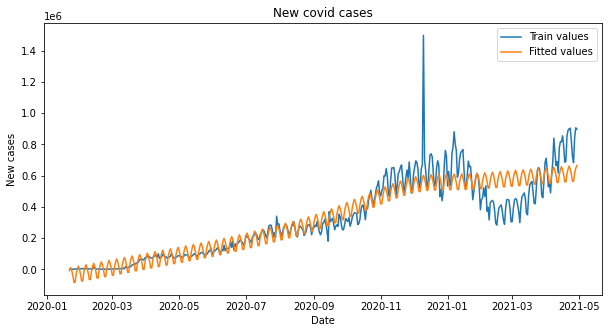

In [ ]:
predictions = model_prophet.predict()
print(f'MAE: {mae(series_train["y"], predictions["yhat"])}')

sns.lineplot(data=series_train, x='ds', y='y')
sns.lineplot(data=predictions, x='ds', y='yhat')

plt.title('New covid cases')

plt.xlabel('Date')
plt.ylabel('New cases')

plt.legend(['Train values', 'Fitted values']);

Видим, что ошибка довольно большая, а подогнанные значения сильно отклоняются от реальных и плохо повторяют изгибы тренда.

Зададим сетку параметров, обучим модель для каждой комбинации параметров и выберем ту, которая лучше всех приближается тренировочные значения.

In [ ]:
params = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

params_grid = ParameterGrid(params)

print(f'Количество переборов: {len(params_grid)}')

Количество переборов: 32


In [ ]:
params_df = pd.DataFrame(columns=['param', 'mae'])

for param in tqdm(params_grid):
  model = Prophet(changepoint_prior_scale=param['changepoint_prior_scale'],
                  seasonality_prior_scale=param['seasonality_prior_scale'],
                  seasonality_mode=param['seasonality_mode'],
                  yearly_seasonality=True,
                  daily_seasonality=False,
                  weekly_seasonality=True)
  model.fit(series_train)
  
  params_df = params_df.append(pd.DataFrame({
      'param': [param],
      'mae': [mae(series_train['y'], model.predict()['yhat'])]
  }))

100%|██████████| 32/32 [02:14<00:00,  4.21s/it]


Выведем 5 наименьших ошибок.

In [ ]:
params_df = params_df.sort_values('mae').reset_index(drop=True)
params_df.head()

,param,mae
0,"{'changepoint_prior_scale': 0.5, 'seasonality_...",19829.545326
1,"{'changepoint_prior_scale': 0.5, 'seasonality_...",19961.251061
2,"{'changepoint_prior_scale': 0.5, 'seasonality_...",20137.640623
3,"{'changepoint_prior_scale': 0.1, 'seasonality_...",21405.781385
4,"{'changepoint_prior_scale': 0.1, 'seasonality_...",21505.534700


Нам удалось уменьшить ошибку с 66204 до 19829!

Выберем комбинацию с наименьшей абсолютной ошибкой. Выведем эту комбинацию и обучим на ней модель.

In [ ]:
params_df.iloc[0]['param']

{'changepoint_prior_scale': 0.5,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.1}

In [ ]:
model_prophet = Prophet(changepoint_prior_scale=0.5,
                        seasonality_prior_scale=0.1,
                        seasonality_mode='multiplicative',
                        yearly_seasonality=True,
                        daily_seasonality=False,
                        weekly_seasonality=True)
model_prophet.fit(series_train)

Построим графики для тренировочных, подогнанных, тестовых и спрогнозированных значений и доверительный интервал для последних. Рассчитаем метрику MAE на тренировочных и подогнанных данных.

In [ ]:
forecast_values = model_prophet.predict(model_prophet.make_future_dataframe(periods=series_test.shape[0], freq='d'))[-test_size:]
fitted_values = model_prophet.predict()

# Create lines for all values
trace_real = go.Scatter(x=series_test['ds'], y=series_test['y'], name='Test values')
trace_forecast = go.Scatter(x=series_test['ds'], y=forecast_values['yhat'], name='Forecast values', line=dict(color='orange'))
trace_train = go.Scatter(x=series_train['ds'], y=series_train['y'], name='Train values')
trace_fitted = go.Scatter(x=series_train['ds'], y=fitted_values['yhat'], name='Fitted values')

trace_forecast_lower = go.Scatter(
        name='80% confidence interval',
        x=series_test['ds'],
        y=forecast_values['yhat_lower'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        legendgroup='Confidence interval',
        showlegend=False)
trace_forecast_upper = go.Scatter(
        name='80% confidence interval',
        x=series_test['ds'],
        y=forecast_values['yhat_upper'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        legendgroup='Confidence interval',
        showlegend=True)

# Define the data array
data = [trace_real, trace_forecast, trace_train, trace_fitted,
        trace_forecast_lower, trace_forecast_upper]

# Calculate MAE metric
mae_metric = round(mae(series_train['y'], fitted_values['yhat']))

# Set the title
layout = {'title': f'New COVID-19 cases. MAE: {mae_metric} on train part',
          'yaxis_title': 'New cases',
          'xaxis_title': 'Date'}

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

Оценка модели из библиотеки Facebook Prophet:

**+** Даёт самые точные предсказания для временного ряда

**+** Нет необходимости предобрабатывать временной ряд перед обучением

**-** Долгий подбор параметров

**-** Без подбора параметров модель работает очень плохо

## 5.4. Линейная регрессия

В качестве ряда для прогнозировная выберем количество новых заражений коронавирусом по всему миру.

In [ ]:
time_series = df_gl[['date', 'new_confirmed']]

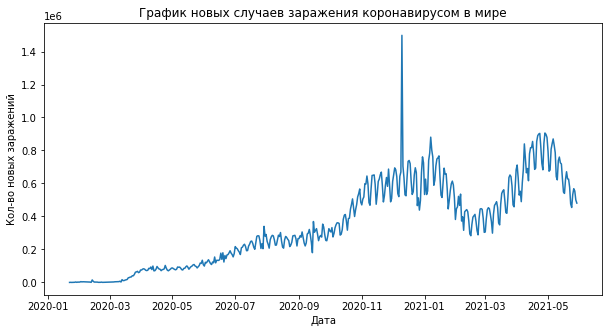

In [ ]:
plt.title('График новых случаев заражения коронавирусом в мире')

plt.xlabel('Дата')
plt.ylabel('Кол-во новых заражений')

sns.lineplot(data=time_series, x='date', y='new_confirmed');

Для обучения линейной регрессии нам необходимо выбрать признаки. В качестве этих признаков возьмём лаги целевой переменной, среднее значение по сезонному значению (дню недели) наблюдения и наклон тренда (отношение ближайшего лага, к значению лага неделю назад).

Функция feature_means возвращает словарь, в котором для каждого значения категориального признака рассчитаны средние значения по выбранному столбцу.

In [ ]:
def feature_means(data, categorical_feature, real_feature):
    return dict(data.groupby(categorical_feature)[real_feature].mean())

Функция prepare_data генерирует признаки и возвращает датафреймы для тренировочной и тестовой выборки.

In [ ]:
def prepare_data(data, target_feature, lag_start=1, lag_end=7, test_size=0.2, output=True):
  data = pd.DataFrame(data.copy())
  lag_end += 1

  # Find size of test dataset slice
  if isinstance(test_size, float):
    test_size = int(len(data) * test_size)

  # Add lags of time series as features
  for i in range(lag_start, lag_end):
      data[f'lag_{i}'] = data[target_feature].shift(i)

  # Add slope feature if possible
  if lag_end - lag_start >= 8:
    data['slope'] = (data[f'lag_{lag_start}'] / data[f'lag_{lag_start+7}']).replace([np.inf, np.nan], 0)

  # Add average of weekday
  data['weekday'] = data['date'].dt.weekday
  data['weekday_average'] = data['weekday'].map(feature_means(data[:-test_size], 'weekday', target_feature))

  # Delete all rows where we could not find lags
  data = data.dropna()
  data = data.reset_index(drop=True)

  # Drop unnecessary features
  data = data.drop('weekday', axis=1)

  # Split on train and test series
  X_train = data[:-test_size].drop(target_feature, axis=1).set_index('date')
  y_train = data[:-test_size][target_feature]
  y_train.index = X_train.index

  X_test = data[-test_size:].drop(target_feature, axis=1).set_index('date')
  y_test = data[-test_size:][target_feature]
  y_test.index = X_test.index

  if output:
    print(f'train size: {X_train.shape[0]}, test size: {X_test.shape[0]}')
  return X_train, X_test, y_train, y_test #, date_train, date_test

In [ ]:
X_train, X_test, y_train, y_test =\
 prepare_data(time_series, target_feature='new_confirmed', lag_start=1, lag_end=14, test_size=30)

train size: 450, test size: 30


In [ ]:
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,slope,weekday_average
date,,,,,,,,,,,,,,,,
2020-02-05,4010.0,3094.0,4749.0,2112.0,1683.0,2069.0,582.0,2648.0,806.0,680.0,495.0,8.0,538.0,0.0,1.514350,354231.940299
2020-02-06,3744.0,4010.0,3094.0,4749.0,2112.0,1683.0,2069.0,582.0,2648.0,806.0,680.0,495.0,8.0,538.0,6.432990,373631.985075
2020-02-07,3182.0,3744.0,4010.0,3094.0,4749.0,2112.0,1683.0,2069.0,582.0,2648.0,806.0,680.0,495.0,8.0,1.537941,350647.363636
2020-02-08,3533.0,3182.0,3744.0,4010.0,3094.0,4749.0,2112.0,1683.0,2069.0,582.0,2648.0,806.0,680.0,495.0,2.099228,317631.227273
2020-02-09,2729.0,3533.0,3182.0,3744.0,4010.0,3094.0,4749.0,2112.0,1683.0,2069.0,582.0,2648.0,806.0,680.0,1.292140,275016.545455


Обучим линейную модель на полученных тренировочных датасетах и сохраним её предсказания для тренировочной и тестовой части.

In [ ]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
fitted_values = model_linear.predict(X_train)
predicted_values = model_linear.predict(X_test)

Рассчитаем стандартное отклонение ошибок на тренировочной части, чтобы построить доверительный интервал.

In [ ]:
# Calculate errors std
std = (y_train - fitted_values).std()

Так как наша линейная модель может прогнозировать только на один день вперёд (в случае, если окно лагов начинается с первого лага), то для построения предсказаний на несколько дней будем использовать ранее предсказанные нашей же моделью значения.

Функция forecast создаёт новые строчки, основанные на переданном датасете, и возвращает предсказанные для них значения целевой метрики и её доверительные интервалы.

In [ ]:
def forecast(model: LinearRegression, df: pd.DataFrame, starting_date=None, n=1, s=7, std=0):
  # Copy dataframe
  df = df.copy()

  # If starting date is missing, define it as the last date of df
  if starting_date == None:
    starting_date = df.last_valid_index()

  # Get lag start and end index
  lag_values = [int(col.replace('lag_', '')) for col in df.columns if 'lag_' in col]
  lag_start = min(lag_values)
  lag_end = max(lag_values) + 1

  new_index = starting_date
  # Append dataframe with n predicted rows
  for i in range(0, n):
    new_index += datetime.timedelta(days=1)
    new_row = pd.DataFrame(index=[new_index])
    new_row[f'lag_{lag_start}'] = model.predict(df.iloc[-lag_start:])[0]

    for j in range(lag_start+1, lag_end):
      new_row[f'lag_{j}'] = df.iloc[-1][f'lag_{j-1}']

    # Add weekday average feature
    new_row['weekday_average'] = df.iloc[-s]['weekday_average']

    # Add slope feature if possible
    if lag_end - lag_start >= 8:
      new_row['slope'] = (new_row[f'lag_{lag_start}'] / new_row[f'lag_{lag_start+7}']).replace(np.inf, 0)

    # Append new row to dataframe
    df = df.append(new_row)

  # Get model predictions on new rows
  new_df = df[(df.shape[0] - n):]
  predictions = pd.Series(model.predict(new_df))
  predictions.index = new_df.index

  # Calculate lower and upper bounds for confidence intervals
  lower_bound = predictions.copy()
  upper_bound = predictions.copy()

  h = 0
  for date in predictions.index:
    h += 1
    lower_bound.loc[date] = predictions.loc[date] - 1.28 * std * sqrt(h)
    upper_bound.loc[date] = predictions.loc[date] + 1.28 * std * sqrt(h)

  return predictions, lower_bound, upper_bound

Спрогнозируем для нашего временного ряда 60 значений (дней) после тренировочной части.

In [ ]:
forecast_values, forecast_lower, forecast_upper = forecast(model_linear, X_train, n=30, s=7, std=std)

Отобразим все полученные значения на одном графике. Рассчитаем метрику MAE на тренировочных и подогнанных значениях.

In [ ]:
# Create lines for real, predicted, train, fitted and forecast values
trace_real = go.Scatter(x=y_test.index, y=y_test, name='Test values')
trace_pred = go.Scatter(x=y_test.index, y=predicted_values, name='Predicted values')
trace_train = go.Scatter(x=y_train.index, y=y_train, name='Train values')
trace_fitted = go.Scatter(x=y_train.index, y=fitted_values, name='Fitted values')
trace_forecast = go.Scatter(x=forecast_values.index, y=forecast_values, name='Forecast values')

trace_forecast_lower = go.Scatter(
        name='80% confidence interval',
        x=y_test.index,
        y=forecast_lower,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        legendgroup='Confidence interval',
        showlegend=False)
trace_forecast_upper = go.Scatter(
        name='80% confidence interval',
        x=y_test.index,
        y=forecast_upper,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        legendgroup='Confidence interval',
        showlegend=True)

# Define the data array
data = [trace_real, trace_pred, trace_train, trace_fitted, trace_forecast,
        trace_forecast_lower, trace_forecast_upper]

# Calculate MAE and MAPE metrics
mae_metric = round(mae(y_train, fitted_values))

# Set the title
layout = {'title': f'New COVID-19 cases. MAE: {mae_metric} on train part',
          'yaxis_title': 'New cases',
          'xaxis_title': 'Date'}

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

Оценка линейной модели:

**+** Очень быстрое обучение

**+** Можно добавлять и убирать любые признаки, что может улучшить предсказания

**+** Нет необходимости предобрабатывать временной ряд перед обучением

**+** Неплохая точность предсказаний

# 6. Построение моделей для всех временных рядов

Попробуем обучить модели и сделать предсказания для всех остальных временных рядов.

Так как мы будем анализировать сразу множество рядов, то лучше всего нам подойдёт линейная модель. Она очень быстро обучается, а также не требует анализа временного ряда перед её использованием.

Посмотрим сколько всего стран есть в датасете.

In [ ]:
df['country'].nunique()

229

Всего 229 стран, однако не все из них подойдут для обучения модели, так как у некоторых из них очень мало наблюдений.

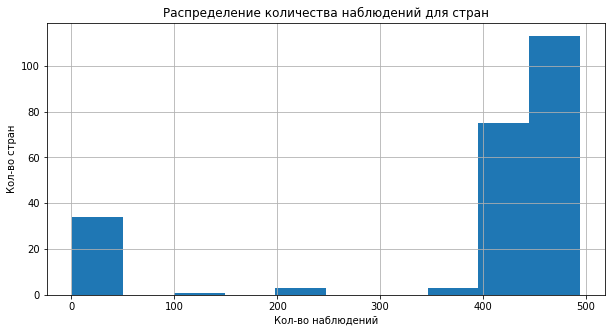

In [ ]:
plt.title('Распределение количества наблюдений для стран')

plt.xlabel('Кол-во наблюдений')
plt.ylabel('Кол-во стран')

df.groupby('country')['date'].nunique().hist();

In [ ]:
(df.groupby('country')['date'].nunique() > 365).sum()

191

Выберем только те страны в которых есть наблюдения хотя бы за 1 год. Таких стран 191 из всех 229.

Сформируем словарь, где по ключу названия страны будет храниться датафрейм и модели для каждого признака.

In [ ]:
countries = {}
min_dates = 365
target_features = ['new_confirmed', 'new_deaths', 'new_recovered']

for country_name in df['country'].unique():
  if df[df['country'] == country_name]['date'].nunique() > 365:
    # Get country rows from dataframe
    df_country = df[df['country'] == country_name].reset_index(drop=True).drop('country', axis=1)

    # Put country dataframe and models to dictionary
    countries[country_name] = {}
    countries[country_name]['df'] = df_country
    for target_feature in target_features:
      countries[country_name][target_feature] = {}
      countries[country_name][target_feature]['model'] = LinearRegression()

# Add global dataframe
countries['World'] = {}
countries['World']['df'] = df.groupby('date').sum().reset_index()
for target_feature in target_features:
  countries['World'][target_feature] = {}
  countries['World'][target_feature]['model'] = LinearRegression()

Создадим функцию для расчета ошибки на временном ряду при помощи кросс-валидации.

In [ ]:
def time_series_cross_validation_score(X, y, n_splits=5):
  tscv = TimeSeriesSplit(n_splits=n_splits)

  mae_score = 0
  for train_dates, valid_dates in tscv.split(X.index):
    model = LinearRegression()
    model.fit(X.iloc[train_dates], y.iloc[train_dates])
    mae_score += mae(model.predict(X.iloc[valid_dates]),
                    y.iloc[valid_dates])
  
  return mae_score / n_splits

Обучим модель для каждого временного ряда. Сохраним тренировочные и тестовые датафреймы.

In [ ]:
lag_start = 1
test_size = 30
tscv = TimeSeriesSplit(n_splits=5)

for country_name in tqdm(countries.keys()):
  country = countries[country_name]

  for target_feature in target_features:
    country_feature = country[target_feature]

    # Find best lag end using cross validation
    best_lag_end = 1
    best_mae = np.inf
    for lag_end in range(1, 31):
      # Get train and test data
      X_train, X_test, y_train, y_test =\
        prepare_data(country['df'][['date', target_feature]],
                    target_feature=target_feature, lag_start=lag_start,
                    lag_end=lag_end, test_size=test_size, output=False)
      
      # Calculate cross validation mae score
      mae_score = time_series_cross_validation_score(X_train, y_train)
      if mae_score < best_mae:
        best_mae = mae_score
        best_lag_end = lag_end

    # Get train and test data with best lag end
    X_train, X_test, y_train, y_test =\
      prepare_data(country['df'][['date', target_feature]],
                  target_feature=target_feature, lag_start=lag_start,
                  lag_end=best_lag_end, test_size=test_size, output=False)

    # Save train and test data to dictionary
    country_feature['X_train'] = X_train
    country_feature['X_test'] = X_test
    country_feature['y_train'] = y_train
    country_feature['y_test'] = y_test

    # Fit model on train data
    country_feature['model'].fit(X_train, y_train)

100%|██████████| 192/192 [12:05<00:00,  3.78s/it]


Создадим функцию plot_country, которая будет выводить график тренировочных, подогнанных, тестовых, предсказанных и спрогнозированных значений, а также рассчитывать метрики MAE и MAPE на тестовых и предсказанных значениях.

In [ ]:
def plot_country(country_name: str, target_feature='new_confirmed', forecast_n=7):
  # Features dictionary for graph title
  feature_title = {'new_confirmed': 'cases',
                   'new_deaths': 'deaths',
                   'new_recovered': 'recoveries'}

  country_feature = countries[country_name][target_feature]

  # Make predictions
  prediction = country_feature['model'].predict(country_feature['X_test'])
  fitted_values = country_feature['model'].predict(country_feature['X_train'])
  y_test = country_feature['y_test']
  y_train = country_feature['y_train']

  # Calculate errors std
  std = (y_train - fitted_values).std()

  # Calculate forecast values and its confidence intervals
  forecast_values, forecast_lower, forecast_upper =\
     forecast(country_feature['model'], country_feature['X_test'], n=forecast_n, std=std)

  # Create lines for real, predicted, train, fitted and forecast values
  trace_real = go.Scatter(x=y_test.index, y=y_test, name='Test values')
  trace_pred = go.Scatter(x=y_test.index, y=prediction, name='Predicted values')
  trace_train = go.Scatter(x=y_train.index, y=y_train, name='Train values')
  trace_fitted = go.Scatter(x=y_train.index, y=fitted_values, name='Fitted values')
  trace_forecast = go.Scatter(x=forecast_values.index, y=forecast_values, name='Forecast values')

  trace_forecast_lower = go.Scatter(
          name='Confidence interval',
          x=forecast_lower.index,
          y=forecast_lower,
          mode='lines',
          marker=dict(color="#444"),
          line=dict(width=0),
          legendgroup='Confidence interval',
          showlegend=False)
  trace_forecast_upper = go.Scatter(
          name='Confidence interval',
          x=forecast_upper.index,
          y=forecast_upper,
          marker=dict(color="#444"),
          line=dict(width=0),
          mode='lines',
          fillcolor='rgba(68, 68, 68, 0.3)',
          fill='tonexty',
          legendgroup='Confidence interval',
          showlegend=True)

  # Define the data array
  data = [trace_real, trace_pred, trace_train, trace_fitted, trace_forecast,
          trace_forecast_lower, trace_forecast_upper]

  # Calculate MAE and MAPE metrics
  mae_metric = round(mae(y_test.values, prediction))
  # Do not count zero values when calculating MAPE
  nonzero_indices = y_test.values.nonzero()
  y_test_mape = np.take(y_test.values, nonzero_indices)
  prediction_mape = np.take(prediction, nonzero_indices)
  mape_metric = round(mape(y_test_mape, prediction_mape) * 100, 2)

  # Set the title
  layout = {'title': f'New COVID-19 {feature_title[target_feature]} in {country_name}. MAE: {mae_metric}, MAPE: {mape_metric}% on test part',
            'yaxis_title': f'New {feature_title[target_feature]}',
            'xaxis_title': f'Date'}

  # Create a Figure and plot it
  fig = go.Figure(data=data, layout=layout)
  fig.show(renderer="colab")

Построим несколько графиков для разных стран и признаков.

In [ ]:
plot_country('World', target_feature='new_confirmed', forecast_n=120)

In [ ]:
plot_country('Italy', target_feature='new_confirmed', forecast_n=120)

In [ ]:
plot_country('Turkey', target_feature='new_deaths', forecast_n=120)

In [ ]:
plot_country('Poland', target_feature='new_recovered', forecast_n=120)

# 7. Вывод

В ходе исследования были найдены данные о количестве случаев заражения, смерти и выздоровлений от коронавируса. Они были проанализированы, а также были построены их визуализации.

Я обучил и сравнил 4 модели для прогнозирования временных рядов. Выяснилось, что модель из библиотеки Facebook Prophet обладает наилучшей точностью, а линейная регрессия является самой быстрой и гибкой.

Был сделан вывод, что для прогнозирования большого количества разных временных рядов лучше всего подходит линейная регрессия.

Для 191 страны были обучены модели прогнозирования новых заражений, смертей и выздоровлений от коронавируса.